# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


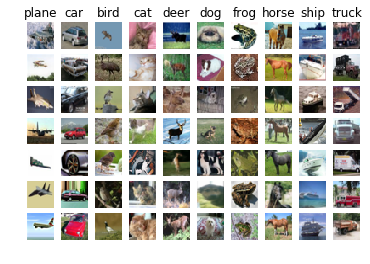

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


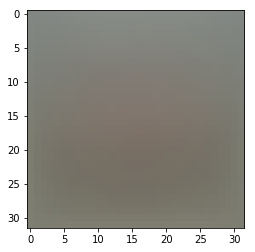

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))
print('grad: {}'.format(grad))

loss: 8.740918
grad: [[-1.66400412e+01 -1.92639212e+00  5.00392122e-01 ...  3.79702776e+00
  -3.28858389e+01 -3.57852963e+01]
 [-2.69920639e+01 -1.63305919e-01  5.98930592e+00 ...  4.94580816e+00
  -3.99849314e+01 -4.19129224e+01]
 [-4.50082353e+01 -1.81000890e+00  2.03160089e+01 ...  9.58087020e+00
  -5.30556183e+01 -5.53841731e+01]
 ...
 [-1.31773677e+01 -1.37075445e+00  4.74075445e+00 ...  1.57543510e+00
   6.43119086e+00 -1.34100865e+01]
 [-2.35783546e+01 -6.60318371e+00  1.10951837e+01 ...  2.03339486e+01
  -4.85912800e+00 -1.55660686e+01]
 [ 1.05999999e-01  3.79999999e-02 -3.80000000e-02 ... -1.19999999e-01
   1.68000001e-01 -1.60000000e-01]]


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 12.165322 analytic: 12.165322, relative error: 2.866598e-11
numerical: -19.618029 analytic: -19.618029, relative error: 2.737286e-11
numerical: 1.150914 analytic: 1.150914, relative error: 1.629098e-10
numerical: 30.131563 analytic: 30.131563, relative error: 9.810723e-12
numerical: 0.667414 analytic: 0.667414, relative error: 3.591671e-10
numerical: -8.790998 analytic: -8.790998, relative error: 2.907419e-12
numerical: 1.831033 analytic: 1.831033, relative error: 7.095187e-11
numerical: 2.607221 analytic: 2.607221, relative error: 1.066727e-10
numerical: 10.843939 analytic: 10.843939, relative error: 4.132985e-11
numerical: 9.153957 analytic: 9.153957, relative error: 2.586538e-11
numerical: -17.065373 analytic: -17.064080, relative error: 3.790102e-05
numerical: -6.530135 analytic: -6.525797, relative error: 3.323068e-04
numerical: -8.442148 analytic: -8.439446, relative error: 1.600676e-04
numerical: 5.029126 analytic: 5.030655, relative error: 1.520092e-04
numerical: 28.

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** 

Such discrepancy can be caused by the hinge function having a kink where the score of the correct class is 1 (delta) higher than the score of the class it is compared to. It is a result of max(a, b) function not being differantiable at a=b

It is not a reason for concern, as such situation does not occur very often.

An example in one dimension would be checking the gradient of function:
f(x) = max(0,x) at point x = -5e6 with numerical gradient step dx = 1e5
analytical derivative df/dx=0 at this point, while numerical estimation is 1/2

You would encounter such situation less often by lowering the numerical gradient step.

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized, svm_loss_half_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.740918e+00 computed in 0.134315s
[[0. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(500,)
Vectorized loss: 8.740918e+00 computed in 0.009155s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))
print()

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
print(grad_naive)
print("####################")
print(grad_vectorized)
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.106486s
[[0. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(500,)
Vectorized loss and gradient: computed in 0.007974s

[[-1.66400412e+01 -1.92639212e+00  5.00392122e-01 ...  3.79702776e+00
  -3.28858389e+01 -3.57852963e+01]
 [-2.69920639e+01 -1.63305919e-01  5.98930592e+00 ...  4.94580816e+00
  -3.99849314e+01 -4.19129224e+01]
 [-4.50082353e+01 -1.81000890e+00  2.03160089e+01 ...  9.58087020e+00
  -5.30556183e+01 -5.53841731e+01]
 ...
 [-1.31773677e+01 -1.37075445e+00  4.74075445e+00 ...  1.57543510e+00
   6.43119086e+00 -1.34100865e+01]
 [-2.35783546e+01 -6.60318371e+00  1.10951837e+01 ...  2.03339486e+01
  -4.85912800e+00 -1.55660686e+01]
 [ 1.05999999e-01  3.79999999e-02 -3.80000000e-02 ... -1.19999999e-01
   1.68000001e-01 -1.60000000e-01]]
####################
[[-1.66400412e+01 -1.92639212e+00  5.00392122e-01 ...  3.79702776e+00
  -3.28858

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [29]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()

loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 778.989195
iteration 100 / 1500: loss 467.065433
iteration 200 / 1500: loss 283.543496
iteration 300 / 1500: loss 172.835886
iteration 400 / 1500: loss 105.678823
iteration 500 / 1500: loss 65.924485
iteration 600 / 1500: loss 42.140304
iteration 700 / 1500: loss 26.948930
iteration 800 / 1500: loss 18.502982
iteration 900 / 1500: loss 13.663720
iteration 1000 / 1500: loss 10.942212
iteration 1100 / 1500: loss 7.865208
iteration 1200 / 1500: loss 6.954635
iteration 1300 / 1500: loss 6.409974
iteration 1400 / 1500: loss 6.010638
That took 7.141750s


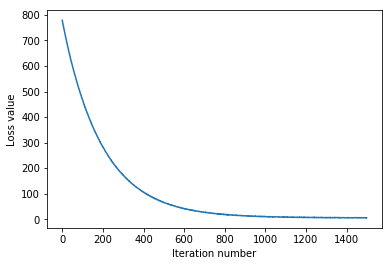

In [30]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [44]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.379245
validation accuracy: 0.384000


In [133]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
#learning_rates = [1e-8, 5e-8, 7.5e-8, 1e-7, 2.5e-7 ,5e-7, 5e-6]
learning_rates = np.logspace(-7, -6, num=10)
regularization_strengths = np.logspace(3, 5, num=10)

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_va = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
all_it = len(learning_rates) * len(regularization_strengths)
cnt_it = 0
for lr in learning_rates:
  for rs in regularization_strengths:
    svm = LinearSVM() 
    cnt_it += 1
    
    print('iteration {}/{}'.format(cnt_it, all_it))
    loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=2000, verbose=False)

    y_train_pred = svm.predict(X_train) # training accuracy
    y_val_pred = svm.predict(X_val) #validation accuracy
    
    ta = np.mean(y_train == y_train_pred)
    va = np.mean(y_val == y_val_pred)
    
    if va > best_va:
      best_va = va
      best_svm = svm
      best_lr = lr
      best_rs = rs
      
    results[(lr, rs)] =  (ta, va)
    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_va)

iteration 1/100
iteration 2/100
iteration 3/100
iteration 4/100
iteration 5/100
iteration 6/100
iteration 7/100
iteration 8/100
iteration 9/100
iteration 10/100
iteration 11/100
iteration 12/100
iteration 13/100
iteration 14/100
iteration 15/100
iteration 16/100
iteration 17/100
iteration 18/100
iteration 19/100
iteration 20/100
iteration 21/100
iteration 22/100
iteration 23/100
iteration 24/100
iteration 25/100
iteration 26/100
iteration 27/100
iteration 28/100
iteration 29/100
iteration 30/100
iteration 31/100
iteration 32/100
iteration 33/100
iteration 34/100
iteration 35/100
iteration 36/100
iteration 37/100
iteration 38/100
iteration 39/100
iteration 40/100
iteration 41/100
iteration 42/100
iteration 43/100
iteration 44/100
iteration 45/100
iteration 46/100
iteration 47/100
iteration 48/100
iteration 49/100
iteration 50/100
iteration 51/100
iteration 52/100
iteration 53/100
iteration 54/100
iteration 55/100
iteration 56/100
iteration 57/100
iteration 58/100
iteration 59/100
iterat

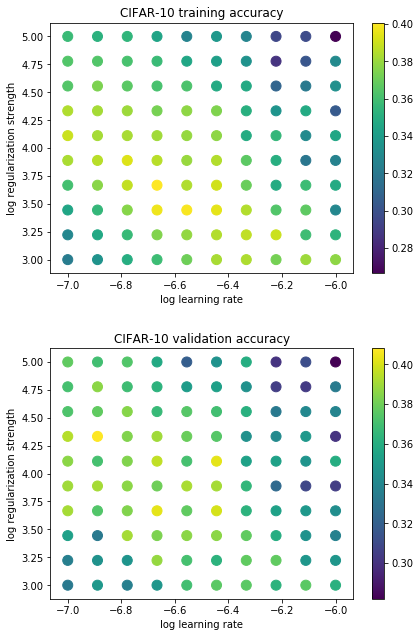

In [134]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

plt.subplots_adjust(bottom=0, right=1, top=2, hspace=0.3)

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [151]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.376000


In [153]:
#Check if I can do any better by further retraining the best model
from copy import copy

bester_svm = copy(best_svm)
extra_it = [int(fl) for fl in [3e3, 5e3, 1e4, 3e4]]
results_retrained = {}

for e_it in extra_it:
  loss = bester_svm.train(X_train, y_train, learning_rate=best_lr, reg=best_rs,
                                   num_iters=e_it, verbose=True)
  y_test_pred = bester_svm.predict(X_test)
  test_accuracy = np.mean(y_test == y_test_pred)
  
  results_retrained[e_it] = (loss[-1], test_accuracy)
  

iteration 0 / 3000: loss 5.301358
iteration 100 / 3000: loss 5.899372
iteration 200 / 3000: loss 5.023826
iteration 300 / 3000: loss 5.381999
iteration 400 / 3000: loss 5.222072
iteration 500 / 3000: loss 5.085674
iteration 600 / 3000: loss 5.089374
iteration 700 / 3000: loss 5.384018
iteration 800 / 3000: loss 5.281726
iteration 900 / 3000: loss 5.260785
iteration 1000 / 3000: loss 5.305121
iteration 1100 / 3000: loss 5.398482
iteration 1200 / 3000: loss 5.703619
iteration 1300 / 3000: loss 5.626862
iteration 1400 / 3000: loss 5.846770
iteration 1500 / 3000: loss 4.942374
iteration 1600 / 3000: loss 4.839266
iteration 1700 / 3000: loss 5.367786
iteration 1800 / 3000: loss 5.307318
iteration 1900 / 3000: loss 5.274282
iteration 2000 / 3000: loss 4.991074
iteration 2100 / 3000: loss 5.223189
iteration 2200 / 3000: loss 5.319240
iteration 2300 / 3000: loss 5.698214
iteration 2400 / 3000: loss 5.824911
iteration 2500 / 3000: loss 5.689504
iteration 2600 / 3000: loss 5.192576
iteration 270

iteration 3900 / 30000: loss 5.144721
iteration 4000 / 30000: loss 5.905343
iteration 4100 / 30000: loss 5.528043
iteration 4200 / 30000: loss 5.476088
iteration 4300 / 30000: loss 5.561228
iteration 4400 / 30000: loss 5.583965
iteration 4500 / 30000: loss 6.083618
iteration 4600 / 30000: loss 5.263561
iteration 4700 / 30000: loss 5.810809
iteration 4800 / 30000: loss 5.128087
iteration 4900 / 30000: loss 5.214737
iteration 5000 / 30000: loss 5.120138
iteration 5100 / 30000: loss 5.542179
iteration 5200 / 30000: loss 4.653554
iteration 5300 / 30000: loss 4.860233
iteration 5400 / 30000: loss 5.586240
iteration 5500 / 30000: loss 5.205225
iteration 5600 / 30000: loss 5.102110
iteration 5700 / 30000: loss 5.597341
iteration 5800 / 30000: loss 5.418351
iteration 5900 / 30000: loss 4.809463
iteration 6000 / 30000: loss 5.344824
iteration 6100 / 30000: loss 5.541753
iteration 6200 / 30000: loss 4.908509
iteration 6300 / 30000: loss 4.904182
iteration 6400 / 30000: loss 5.365083
iteration 65

iteration 25100 / 30000: loss 5.740086
iteration 25200 / 30000: loss 5.500675
iteration 25300 / 30000: loss 5.770247
iteration 25400 / 30000: loss 4.719143
iteration 25500 / 30000: loss 5.555311
iteration 25600 / 30000: loss 5.391544
iteration 25700 / 30000: loss 5.660006
iteration 25800 / 30000: loss 5.585906
iteration 25900 / 30000: loss 5.448911
iteration 26000 / 30000: loss 5.623257
iteration 26100 / 30000: loss 5.750097
iteration 26200 / 30000: loss 5.639999
iteration 26300 / 30000: loss 4.975403
iteration 26400 / 30000: loss 5.470695
iteration 26500 / 30000: loss 5.897268
iteration 26600 / 30000: loss 5.298203
iteration 26700 / 30000: loss 5.864533
iteration 26800 / 30000: loss 5.182263
iteration 26900 / 30000: loss 5.363420
iteration 27000 / 30000: loss 5.458046
iteration 27100 / 30000: loss 4.944664
iteration 27200 / 30000: loss 5.679967
iteration 27300 / 30000: loss 5.541453
iteration 27400 / 30000: loss 5.448146
iteration 27500 / 30000: loss 5.120926
iteration 27600 / 30000: 

{3000: (5.136312886588422, 0.389), 5000: (4.926649286289967, 0.372), 10000: (5.562352895053831, 0.373), 30000: (5.067402817827936, 0.386)}


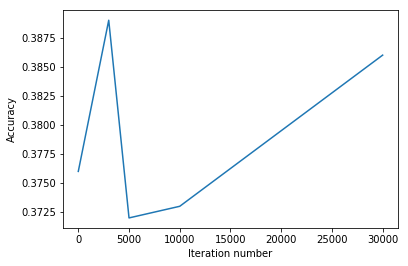

In [168]:
print(results_retrained)
iterations = [0, 3e3, 5e3, 1e4, 3e4]
accuracies = [0.376, 0.389, 0.372, 0.373, 0.386]

plt.plot(iterations, accuracies)
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
plt.show()

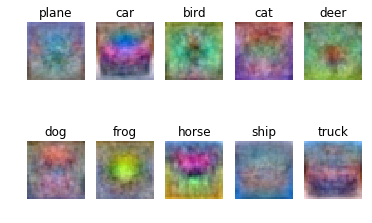

In [169]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** The weight matrices look like templates for the pictures. They try to fit in to most of the pictures in the dataset, therefore they are somewhat distorted - horse appears to have two heads and car seems to be facing both front and to the sides. Depending on regularization loss the pictures have more or less noise in them.